# Run imaging element workflow

This notebook walks you through the steps to run the ephys workflow.  
The workflow requires tiff files collected from scanimage acquisition software and the output data of either CaImAn or Suite2p.  
A typical organization of the files is as follows:  

```
imaging_root_data_dir/
└───<subject1>/                     # Subject name in `subjects.csv`
│   └───<session0>/                 # Session directory in `sessions.csv`
│   │   │   scan_0001.tif
│   │   │   scan_0002.tif
│   │   │   scan_0003.tif
│   │   │   ...
│   │   └───suite2p/
│   │       │   ops1.npy
│   │       └───plane0/
│   │       │   │   ops.npy
│   │       │   │   spks.npy
│   │       │   │   stat.npy
│   │       │   │   ...
│   │       └───plane1/
│   │           │   ops.npy
│   │           │   spks.npy
│   │           │   stat.npy
│   │           │   ...
│   │   └───caiman/
│   │       │   analysis_results.hdf5
│   └───<session1>/                 # Session directory in `sessions.csv`
│   │   │   scan_0001.tif
│   │   │   scan_0002.tif
│   │   │   ...
└───<subject2>/                     # Subject name in `subjects.csv`
│   │   ...
```



Let's start by importing the relevant modules.

In [1]:
import datajoint as dj
import numpy as np
from u19_pipeline import imaging, acquisition, subject
from u19_pipeline.imaging_element import imaging_element, scan_element, get_scan_image_files
from u19_pipeline.ingest.imaging_element_ingest import process_scan
import pathlib

Connecting shans@datajoint00.pni.princeton.edu:3306


The module imaging_element contains all the tables designed in the DataJoint imaging element, we could draw the diagram to see the schema structures

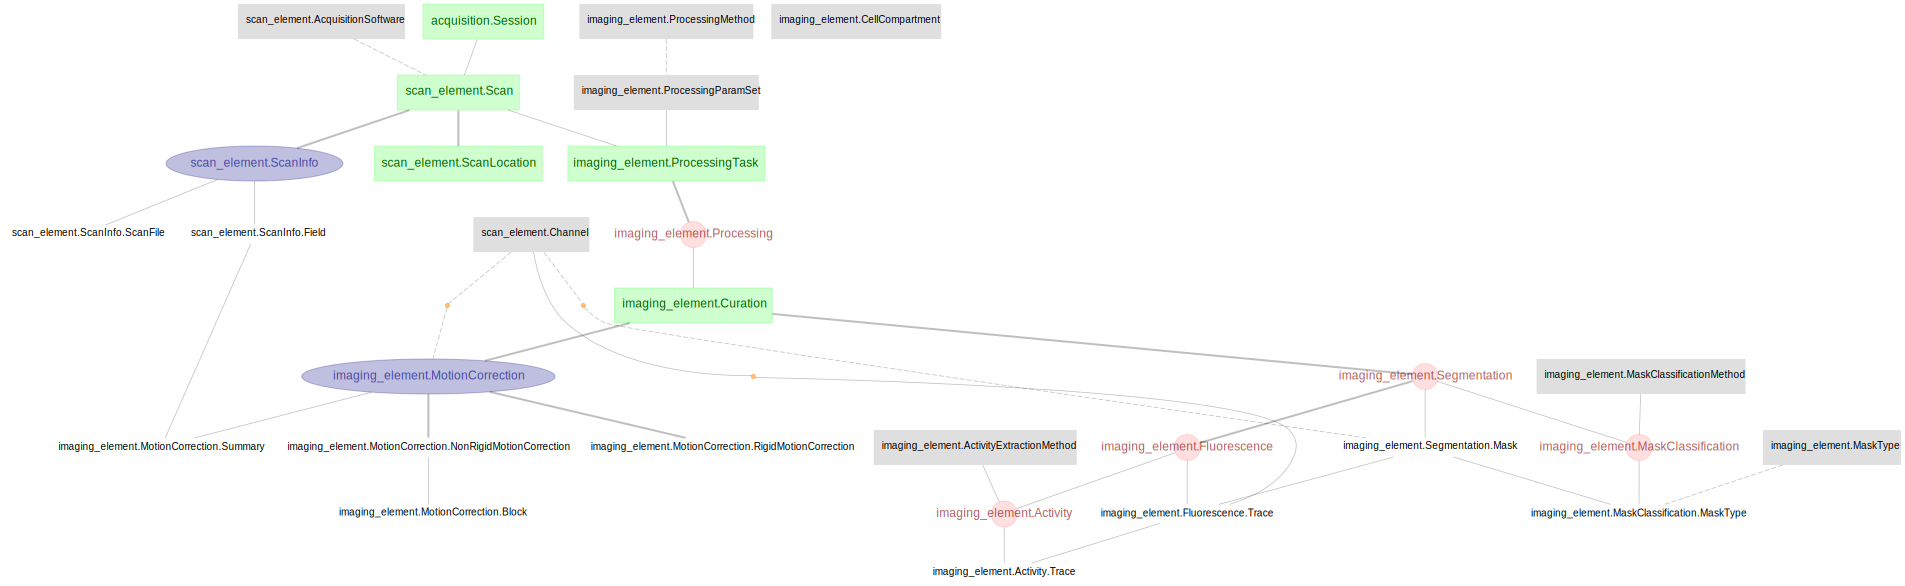

In [2]:
dj.Diagram(acquisition.Session) + dj.Diagram(scan_element) + dj.Diagram(imaging_element)

# Ingest into table `scan_element.Scan`

In the U19 pipeline, we have a table `imaging.Scan` that stores the scan information, in the imaging element, there are native scan tables to take care of the Scan meta information. We provided a function `u19_pipeline.ingest_imaging_element_ingest.process_scan` that ingest into table `scan_element.Scan` using information in the existing pipeline, for example the path to the tiff files.

In [3]:
key = (imaging.Scan & dict(session_date='2021-03-02', subject_fullname='testuser_imaging_pipe1')).fetch1('KEY')
process_scan(key)

In [4]:
scan_element.ScanInfo.populate(key, display_progress=True)

ScanInfo: 0it [00:00, ?it/s]


# Process Suite2p output

We are then able to process the Suite2p output. 
To do that, we need to ingest into several manual tables for Suite2p.

## Ingest into ProcessingParamSet for Suite2p

In [8]:
# ingest parameters for Suite2p
pars = {
    'look_one_level_down': 0.0,
    'fast_disk': [],
    'delete_bin': False,
    'mesoscan': False,
    'h5py': [],
    'h5py_key': 'data',
    'save_path0': [],
    'subfolders': [],
    'nplanes': 1,
    'nchannels': 1,
    'functional_chan': 1,
    'tau': 1.0,
    'fs': 10.0,
    'force_sktiff': False,
    'preclassify': 0.0,
    'save_mat': False,
    'combined': True,
    'aspect': 1.0,
    'do_bidiphase': False,
    'bidiphase': 0.0,
    'do_registration': True,
    'keep_movie_raw': False,
    'nimg_init': 300,
    'batch_size': 500,
    'maxregshift': 0.1,
    'align_by_chan': 1,
    'reg_tif': False,
    'reg_tif_chan2': False,
    'subpixel': 10,
    'smooth_sigma': 1.15,
    'th_badframes': 1.0,
    'pad_fft': False,
    'nonrigid': True,
    'block_size': [128, 128],
    'snr_thresh': 1.2,
    'maxregshiftNR': 5.0,
    '1Preg': False,
    'spatial_hp': 50.0,
    'pre_smooth': 2.0,
    'spatial_taper': 50.0,
    'roidetect': True,
    'sparse_mode': False,
    'diameter': 12,
    'spatial_scale': 0,
    'connected': True,
    'nbinned': 5000,
    'max_iterations': 20,
    'threshold_scaling': 1.0,
    'max_overlap': 0.75,
    'high_pass': 100.0,
    'inner_neuropil_radius': 2,
    'min_neuropil_pixels': 350,
    'allow_overlap': False,
    'chan2_thres': 0.65,
    'baseline': 'maximin',
    'win_baseline': 60.0,
    'sig_baseline': 10.0,
    'prctile_baseline': 8.0,
    'neucoeff': 0.7,
    'xrange': np.array([0, 0]),
    'yrange': np.array([0, 0])}


imaging_element.ProcessingParamSet.insert_new_params(
    'suite2p', 0, 'Calcium imaging analysis with Suite2p using default Suite2p parameters', pars)

In [9]:
imaging_element.ProcessingParamSet()

paramset_idx,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,suite2p,Calcium imaging analysis with Suite2p using default Suite2p parameters,be32de46-f21d-d714-d131-ec89817de806,=BLOB=


## Ingest into ProcessingTask

Then ingest into the table ProcessingTask, this table serves as a mark when a Suite2p session is done. The field `processing_output_dir` is the directory that contains the Suite2p output. In the future release of imaging element, this table serves as a manual trigger to run Suite2p and `processing_output_dir` will be the target directory that saves the output.

In [11]:
scan_keys = (scan_element.Scan & key).fetch('KEY')
for scan_key in scan_keys:
    session_key = (acquisition.Session & scan_key).fetch1('KEY')
    scan_dir = pathlib.Path((imaging.FieldOfView & session_key &
                             {'fov': scan_key['scan_id']}).fetch1('fov_directory')) 
    imaging_element.ProcessingTask.insert1(
        dict(**scan_key, paramset_idx=0, processing_output_dir=pathlib.Path.joinpath(scan_dir, 'suite2p/')), skip_duplicates=True)
imaging_element.ProcessingTask()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
emdiamanti_gps8,2021-02-09,0,1,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI01_z1/suite2p,load
emdiamanti_gps8,2021-02-09,0,2,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI02_z1/suite2p,load
emdiamanti_gps8,2021-02-09,0,3,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI03_z1/suite2p,load
testuser_imaging_pipe1,2021-03-02,0,1,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI01_z1/suite2p/,load
testuser_imaging_pipe1,2021-03-02,0,2,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI02_z1/suite2p,load
testuser_imaging_pipe1,2021-03-02,0,3,0,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI03_z1/suite2p,load


Then we are able to populate table `Processing`, `Processing` table is currently just confirming the existence of the suite2p (or caiman) outputs. In future releases, it will be table that call Suite2p processing.

In [11]:
imaging_element.Processing.populate(display_progress=True)

Processing: 0it [00:00, ?it/s]


In [16]:
imaging_element.Processing()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,"processing_time time of generation of this set of processed, segmented results"
emdiamanti_gps8,2021-02-09,0,1,0,2021-02-28 00:32:23
emdiamanti_gps8,2021-02-09,0,2,0,2021-02-28 01:31:33
emdiamanti_gps8,2021-02-09,0,3,0,2021-02-28 02:13:31
testuser_imaging_pipe1,2021-03-02,0,1,0,2021-03-11 11:54:11
testuser_imaging_pipe1,2021-03-02,0,2,0,2021-03-11 11:54:34
testuser_imaging_pipe1,2021-03-02,0,3,0,2021-03-11 11:55:02


# Insert new Curation following the ProcessingTask

The next step in the pipeline is the curation of motion corection and segmentation results.

+ If a manual curation was implemented, an entry needs to be manually inserted into the table `imaging_element.Curation`, which specifies the directory to the curated results in `curation_output_dir`.

+ If we would like to use the processed outcome directly, an entry is also needed in `imaging_element.Curation`. A method `create1_from_processing_task` was provided to help this insertion. It copies the `processing_output_dir` in `imaging_element.ProcessingTask` to the field `curation_output_dir` in the table `imaging_element.Curation` with a new `curation_id`.

In this example, we create/insert one `imaging_element.Curation` for each `imaging_element.ProcessingTask`, specifying the same output directory.

To this end, we could also make use of a convenient function `imaging_element.Curation().create1_from_processing_task()`, taking a primary key from `Processing`

In [18]:
processing_keys = imaging_element.Processing.fetch('KEY')
for processing_key in processing_keys:
    imaging_element.Curation().create1_from_processing_task(processing_key)

In [21]:
imaging_element.Curation()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
emdiamanti_gps8,2021-02-09,0,1,0,1,2021-02-28 00:32:23,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI01_z1/suite2p,0,
emdiamanti_gps8,2021-02-09,0,2,0,1,2021-02-28 01:31:33,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI02_z1/suite2p,0,
emdiamanti_gps8,2021-02-09,0,3,0,1,2021-02-28 02:13:31,/mnt/bucket/braininit/RigData/mesoscope/imaging/gps8/20210209/ROI03_z1/suite2p,0,
testuser_imaging_pipe1,2021-03-02,0,1,0,1,2021-03-11 11:54:11,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI01_z1/suite2p/,0,
testuser_imaging_pipe1,2021-03-02,0,2,0,1,2021-03-11 11:54:34,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI02_z1/suite2p,0,
testuser_imaging_pipe1,2021-03-02,0,3,0,1,2021-03-11 11:55:02,/mnt/bucket/braininit/RigData/mesoscope/imaging/imaging_pipe1/20210302/ROI03_z1/suite2p,0,


## Motion Correction

In [22]:
imaging_element.MotionCorrection.populate(display_progress=True)

MotionCorrection: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


In [23]:
imaging_element.MotionCorrection()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,curation_id,motion_correct_channel 0-based indexing
emdiamanti_gps8,2021-02-09,0,1,0,1,0
emdiamanti_gps8,2021-02-09,0,2,0,1,0
emdiamanti_gps8,2021-02-09,0,3,0,1,0
testuser_imaging_pipe1,2021-03-02,0,1,0,1,0
testuser_imaging_pipe1,2021-03-02,0,2,0,1,0
testuser_imaging_pipe1,2021-03-02,0,3,0,1,0


## Process Segmentation result and downstream tables to extract Fluorescence and Activity

In [24]:
imaging_element.Segmentation.populate(display_progress=True)

Segmentation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


In [25]:
# This table drives the extraction of fluorescent traces of each mask
imaging_element.Fluorescence.populate(display_progress=True)

Fluorescence: 100%|██████████| 6/6 [02:35<00:00, 25.86s/it]


In [45]:
imaging_element.Fluorescence.Trace()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,curation_id,mask,fluo_channel 0-based indexing,fluorescence fluorescence trace associated with this mask,neuropil_fluorescence Neuropil fluorescence trace
emdiamanti_gps8,2021-02-09,0,1,0,1,0,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,1,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,2,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,3,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,4,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,5,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,6,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,7,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,8,0,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,9,0,=BLOB=,=BLOB=


In [26]:
# This table computes the activity such as df/f or deconvoluted inferred spikes
imaging_element.Activity.populate(display_progress=True)

Activity: 100%|██████████| 6/6 [00:24<00:00,  4.12s/it]


## Visualize masks

The segmented masks are in the table `imaging_element.Segmentation.Mask`

In [29]:
imaging_element.Segmentation.Mask()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,scan_id,paramset_idx,curation_id,mask,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
emdiamanti_gps8,2021-02-09,0,1,0,1,0,0,162,458,54,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,1,0,117,458,459,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,2,0,256,366,210,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,3,0,157,53,263,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,4,0,176,396,301,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,5,0,128,300,56,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,6,0,159,53,313,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,7,0,214,340,54,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,8,0,188,458,178,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
emdiamanti_gps8,2021-02-09,0,1,0,1,9,0,122,55,100,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [32]:
scan_key = (scan_element.Scan & key).fetch('KEY')[0]

In [33]:
px_height, px_width = (scan_element.ScanInfo().Field & scan_key).fetch1('px_height', 'px_width')
masks = (imaging_element.Segmentation.Mask & scan_key & 'curation_id=1').fetch()

In [34]:
img = np.full((px_height, px_width), np.nan)

In [35]:
for mask in masks:
    img[mask['mask_xpix'], mask['mask_ypix']] = mask['mask_weights']

In [42]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


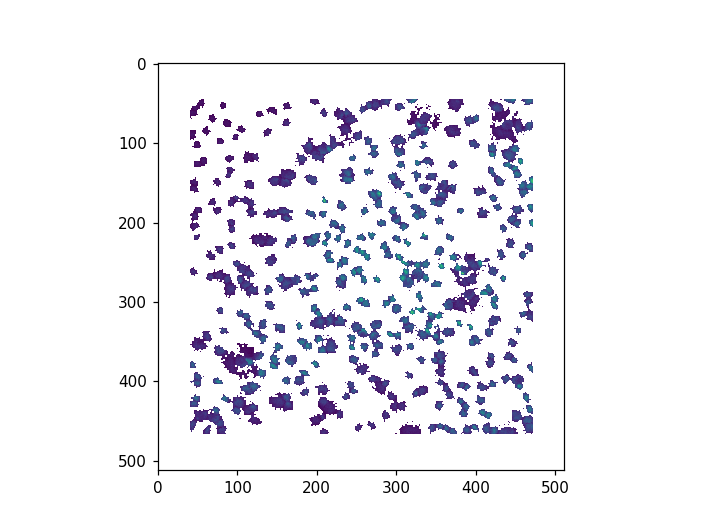

In [43]:
plt.imshow(img)